*Note*: *This is a very advanced blog post which is recommended only to students who have completed most other blog posts, especially including the implementation of logistic regression.* 


A *sparse kernel machine* is a [kernelized linear model](https://www.philchodrow.prof/ml-notes/chapters/50-kernel-methods.html) which has been modified to ensure that many entries of the weight vector $\mathbf{a}$ are equal to exactly zero. [The most influential sparse kernel machine is the [support vector machine](https://en.wikipedia.org/wiki/Support_vector_machine), which corresponds to the use of the hinge loss and $\ell_2$ regularization.]{.aside}

In this blog post, we'll implement *sparse kernelized logistic regression*. In sparse kernelized logistic regression, the score of a feature vector $\mathbf{x}$ is computed as 

$$
\begin{aligned}
    s = \sum_{i = 1}^n a_i k(\mathbf{x}, \mathbf{x}_{t,i})\;,
\end{aligned}
$$

where $\mathbf{x}_{t,i}$ is the $i$th entry of the training data and $k$ is a positive-definite kernel. It is convenient to write this in matrix form: 

$$
\begin{aligned}
    \mathbf{s} = \mathbf{K}(\mathbf{X}, \mathbf{X}_t)^T \mathbf{a}\;. 
\end{aligned}
$$


The loss function for sparse kernel logistic regression on data set $\mathbf{X} \in \mathbb{R}^{m\times p}$ is  

$$
\begin{aligned}
    L(\mathbf{a}) = -\frac{1}{m} \sum_{j = 1}^m \left[y_j\log \sigma(s_j) + (1-y_j)\log (1-\sigma(s_j)) \right] + \lambda \lVert \mathbf{a} \rVert_1\;. 
\end{aligned}
$$

Here, $\lambda$ is a regularization strength and $\lVert \mathbf{a} \rVert_1$ is the $\ell_1$ norm of $\mathbf{a}$ which we discussed [in our lecture on regularization](https://www.philchodrow.prof/ml-notes/chapters/30-features-regularization.html). This specific choice of norm is what will make our model sparse. For a fixed choice of $\alpha$ and the kernel $k$, we can minimize the loss function with respect to $\mathbf{a}$ using gradient descent. 

## Implementation

Please implement sparse kernelized logistic regression. You can do so using an object-oriented API of your choice. Importantly, because the score $s$ on a feature matrix $\mathbf{X}$ must be computed using $\mathbf{K}(\mathbf{X}, \mathbf{X}_t)^T$, you will need to save the training data $\mathbf{X}_t$ as an instance variable of your class. 


Your class should allow the user to specify a positive-definite kernel function as an argument. Here's a very standard one. 

In [1]:
#| include: false
import torch 

In [2]:
def rbf_kernel(X_1, X_2, gamma):
    return torch.exp(-gamma*torch.cdist(X_1, X_2)**2)

You are encouraged but not required to experiment with other kernel functions when completing this assignment. 

## Experiments

Here's some code that allows you to generate a simple data set with a roughly linear separating boundary. 

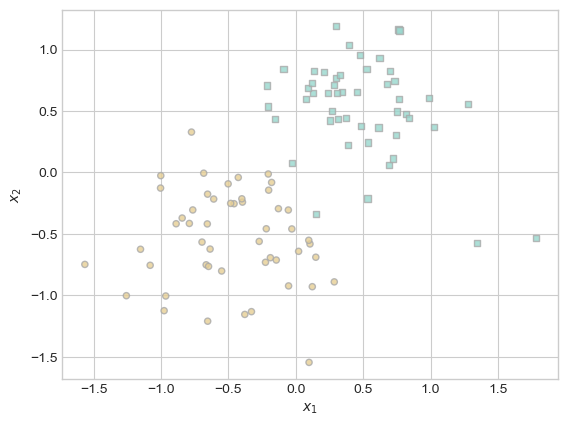

In [3]:
#| code-fold: true
import torch 
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    # X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    X = X - X.mean(dim = 0, keepdim = True)
    return X, y


def plot_classification_data(X, y, ax):
    assert X.shape[1] == 2, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = classification_data(n_points = 100, noise = 0.4)
plot_classification_data(X, y, ax)

Once you have your data set and an implementation of kernel logistic regression, you should be able to use it like this: 

In [4]:
from hidden.sparse_kernel_logistic import KernelLogisticRegression
KR = KernelLogisticRegression(rbf_kernel, lam = 0.1, gamma = 0.1)
KR.fit(X, y, m_epochs = 500000, lr = 0.0001)

Here I have specified that we will do 500,000 epochs of gradient descent with a learning rate of $10^{-4}$.  The parameter `gamma` is a keyword passed to `rbf_kernel` which controls the bandwidth. It's a hyperparameter that can be tuned in cross-validation. 

On my computer, running this code takes a little less than a minute.

Inspecting the weight vector `KR.a` shows that most of the entries are very close to zero. 

In [5]:
(1.0*(KR.a > 0.001)).mean()

tensor(0.0700)

The code block below the fold will plot the scores along with the training data, and will highlight the pieces of the training data which have weights distinguishable from 0. 

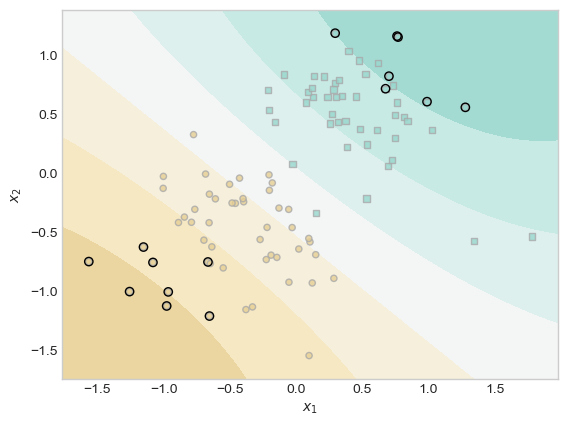

In [6]:
#| code-fold: true
ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_, recompute_kernel = True)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")
# ax.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

### Part A: Basic Experiments 

Please implement experiments with appropriately-labeled visualizations to demonstrate the following: 

1. When $\lambda$ is very large, there may be *only one* point in the training data with a weight distinguishable from zero. 
2. Changing $\gamma$ can result in wigglier decision boundaries. 
3. When the data has a nonlinear pattern (e.g. as generated by [`sklearn.datasets.make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)), kernel methods with appropriate parameters can find this pattern effectively. 

### Part B: Demonstrating Overfitting

Please generate *two* data sets using the same function, one for training and one for testing. Then, show an example in which the wrong choice of $\gamma$ can result in a badly overfit model, as measured by the gap between training and testing performance. To measure performance, I recommend computing ROC curves, although you can also pick a single threshold for the model in order to compute an accuracy. 

## Part C: Writing


1. Please include informative comments throughout your source code **and a thorough docstring** for each meethod.  
2. Please add careful expository writing throughout your blog post. You should describe each experiment and what it is intended to illustrate. You should also ensure that all your plots are legible and have appropriate axis labels and legends. 
3. At the beginning of your blog post, please place a link to your source code on GitHub. After this link, please write an abstract paragraph describing the topic of your post and giving a brief overview of the experiments you performed. 
4. At the conclusion of your blog post, please write a discussion paragraph reminding the reader of what you did and what you learned while doing it. 